# Molecular Embeddings

In [2]:
import multipers as mp
import multipers.ml.signed_measures as mms
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore", UserWarning)
import multipers.data.MOL2 as mdm
import numpy as np

The following provide the code to get the Enrichment Factor and the ROC-AUC from the Cleves-Jain dataset, with our pipeline,
as detailed in our NeurIPS2023 paper [Signed Barcodes as Signed Measures](https://proceedings.neurips.cc/paper_files/paper/2023/hash/d75c474bc01735929a1fab5d0de3b189-Abstract-Conference.html)
The dataset is assumed to be installed in `$HOME/Datasets/Cleves-Jain/`. Note that the convolution implementation slightly changed (c.f. `pipelines/convolutions/convolutions.py`), and Sliced Wasserstein has some randomness, so the results may differ.

As one can see, non-renormalized filtrations performs **significantly better** than its "normalized" counterpart, but choosing non rescaled filtrations is not based on *a priori* information, as in general, one wants each filtration to be comparable, i.e., in the same scale, i.e., normalized.

The parameter to choose for the paper are `resolution = 1000` and `renormalize=True` and a `bandwidth=1`. The grid of the image can either be infered (by choosing a `out_resolution`, or by choosing the same grid as the simplextrees, i.e., `filtration_grid=filtration_grid`)

In [2]:
invariant = "euler" # The topological invariant to compute the signed measure
renormalize = True # Renormalizes the filtration if set to true
degrees = [0] if invariant == "hilbert" else [None]
graph=True

In [3]:
all_pathes = mdm.get_all_JC_path() # retrieves the path of the dataset, in a dictionary 
pathes = mdm.get_data_path_JC()
filtrations=[ # Choose which filtrations to consider, here all available
    "bond_length",
    "atomic_mass", 
    "bond_type",
]
num_parameters = len(filtrations)
ST = mdm.Molecule2SimplexTree(filtrations=filtrations,graph=graph, n_jobs=1) # This pipeline turns molecules into our multiparameter simplextrees
SM = mms.SimplexTree2SignedMeasure(degrees=degrees, # This pipeline turns simplextrees to signed measuresn_jobs=-1, 
    grid_strategy="exact",
    enforce_null_mass=True,
    normalize_filtrations=renormalize,
)
pipeline_sm = Pipeline([ # this combines the two previous pipelines
		("st", ST),
		("sm", SM),
])
pipeline_sm.fit(all_pathes)  # Compiles the pipelines together, it computes : the number of parameters, filtration bounds, the format of the simplextrees ... from the molecule files
filtration_grid = SM._reconversion_grid
sms = mdm.apply_pipeline(pathes=pathes, pipeline=pipeline_sm)  # This computes the signed measures into sms.

Applying pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:05<00:00,  4.08it/s]


Applying pipeline:   0%|                                                                                                                                                                      | 0/23 [00:00<?, ?it/s]

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


Applying pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:03<00:00,  7.14it/s]


Text(0.5, 1.0, "Signed Measure Convolution's Enrichment Factor. AUC = 0.989")

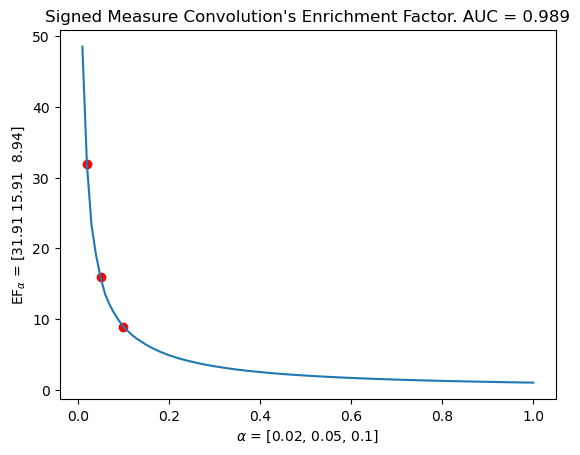

In [4]:
out_resolution = 100 # The resolution of the images. One can increase this to get (slightly) better results
bandwidth=1 # The bandwidth. As this is unsupervised, we have to fix it to 1.
pipeline_img = mms.SignedMeasure2Convolution( # This pipeline turns signed measures to signed measure convolutions
    bandwidth=bandwidth, flatten=True,
    resolution=out_resolution,
    # filtration_grid=filtration_grid,
    grid_strategy="partition",
    )
sms_ = pipeline_sm.fit_transform(all_pathes); pipeline_img.fit(sms_) # This compiles the previous pipeline. It computes the structure of the signed measure, e.g., is it in a sparse format, the bounds, etc.
imgs = mdm.apply_pipeline(pathes=sms, pipeline=pipeline_img) # This computes the convolution (or images)
distances_to_letter, ytest = mdm.img_distances(imgs) # This computes the distances between each target and the rest of the dataset, according to the ToDD paper.
EF = lambda alpha : mdm.get_EF_vector_from_distances(distances_to_letter, ytest, alpha) # This function gets the Enrichment Factor from these distances
mdm.plot_EF_from_distances(EF=EF, alphas=[0.02, 0.05, 0.1]) # Evaluates the EF on a graph
means = []
for distances, labels in zip(distances_to_letter, ytest):
    labels = labels == labels[0]
    means.append(mdm.EF_AUC(distances=distances, labels=labels))
plt.title(f"Signed Measure Convolution's Enrichment Factor. AUC = {np.mean(means).round(decimals=3)}")
# plt.savefig(f"JC_SMI_r{resolution}_i{invariant}_b{bandwidth}_renormalize{renormalize}.png")

Applying pipeline: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:07<00:00,  3.16it/s]


Text(0.5, 1.0, "Hilbert Function's Enrichment Factor. AUC = 0.968")

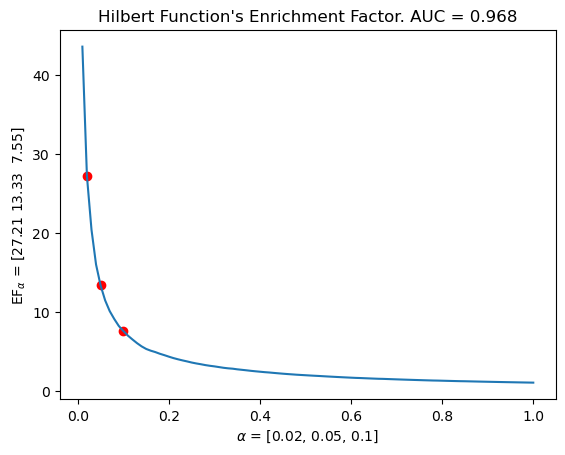

In [5]:
# Same for the undecomposed hilbert function / Euler caracteristic, with the same filtration grid ! i.e. the same information as our vectorizations
pipeline_hilbert = Pipeline([
		("st", ST),
		("sm", SM),
		('smf', mms.SignedMeasureFormatter(integrate=True, flatten=True, resolution=20, grid_strategy='regular')) ## its in fact quicker to integrate the sparse signed measure than compute the non sparse directly (due to the cancelations)
])
pipeline_hilbert.fit(all_pathes)
imgs_hilbert = mdm.apply_pipeline(pathes=pathes, pipeline=pipeline_hilbert)
distances_to_letter, ytest = mdm.img_distances(imgs_hilbert)
EF = lambda alpha : mdm.get_EF_vector_from_distances(distances_to_letter, ytest, alpha)
mdm.plot_EF_from_distances(EF=EF, alphas=[0.02, 0.05, 0.1])
means = []
for distances, labels in zip(distances_to_letter, ytest):
    labels = labels == labels[0]
    means.append(mdm.EF_AUC(distances=distances, labels=labels))
plt.title(f"Hilbert Function's Enrichment Factor. AUC = {np.mean(means).round(decimals=3)}")
# plt.savefig(f"JC_H_r{resolution}_i{invariant}_b{bandwidth}_renormalize{renormalize}.png")

Text(0.5, 1.0, "Sliced Wasserstein's Enrichment Factor. AUC = 0.968")

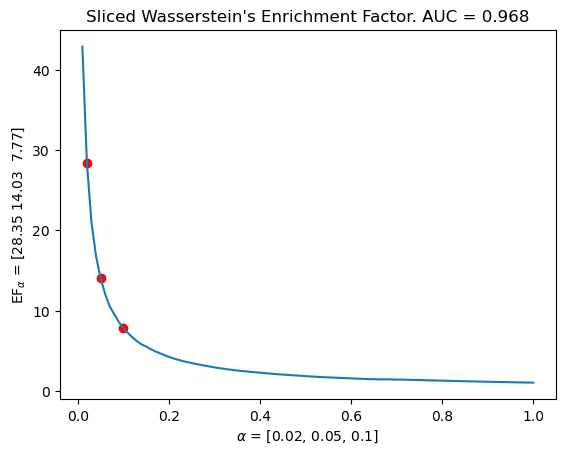

In [6]:
# The same with our signed measure sliced wasserstein kernel.
def swd_distances(img_dict:dict):
    from joblib import Parallel,delayed
    decoy_list = img_dict["decoy"]
    def todo_letter(letter, imgs):
        xtrain, xtest = imgs
        assert len(xtest)>0
        D = mms.SignedMeasure2SlicedWassersteinDistance(num_directions=20, n_jobs=-1).fit(xtrain).transform(xtest + decoy_list)
        letter_ytest = np.array([letter]*len(xtest) + ['0']*len(decoy_list), dtype="<U1")
        return D,letter_ytest
    out = Parallel(n_jobs=-1,prefer="threads")(delayed(todo_letter)(letter, imgs) for letter, imgs in img_dict.items() if len(letter) == 1)
    return [truc for truc,_ in out], [truc for _,truc in out]
distances, ytest = swd_distances(sms)
EF = lambda alpha : mdm.get_EF_vector_from_distances(distances=distances, ytest = ytest, alpha = alpha)
mdm.plot_EF_from_distances(alphas = [0.02, 0.05, 0.1], EF=EF)
means = []
for distances, labels in zip(distances_to_letter, ytest):
    labels = labels == labels[0]
    means.append(mdm.EF_AUC(distances=distances, labels=labels))
plt.title(f"Sliced Wasserstein's Enrichment Factor. AUC = {np.mean(means).round(decimals=3)}")
# plt.savefig(f"JC_SMD_r{resolution}_i{invariant}_b{bandwidth}_renormalize{renormalize}.png")